## Prototype of a real-time phase estimation algorithm
### detect the critical points of the oscillatory signal and map the cycle onto sample count

In [225]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, sosfiltfilt, sosfilt, filtfilt, lfilter
import os
import pandas as pd

In [226]:
regr = LinearRegression()

In [633]:
central_freq = 6
sampling_rate = 1500
# slope = 2*pi / # of corresponding sample counts
default_slope = (2*np.pi)/(sampling_rate/central_freq)
# ignoring the computation time, 62 samples every quarter cycle

num_to_wait = 1
regr_buffer_size = 15
fltr_buffer_size = 50

### create data

In [634]:
t = np.linspace(0, 10, sampling_rate*10)
x = np.sin(2*np.pi*central_freq*t)

### load data

In [635]:
%cd C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\theta_range_sample_data
data_dir = %pwd

data_list = [pd.read_csv(file) for file in next(os.walk(data_dir))[2]]
data_list = [file.iloc[:,0].tolist() for file in data_list]
time_list = [np.arange(len(data))/sampling_rate for data in data_list]

%cd C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\METHODS\clc\offline_analysis

C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\theta_range_sample_data
C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\METHODS\clc\offline_analysis


### Non-causal global filtering

In [636]:
order = 1
lowcut = 4
highcut = 8

butter_filter = butter(order,[lowcut,highcut],'bp',fs=sampling_rate,output='sos')

filtered_data = [sosfiltfilt(butter_filter,data) for data in data_list]

<IPython.core.display.Javascript object>


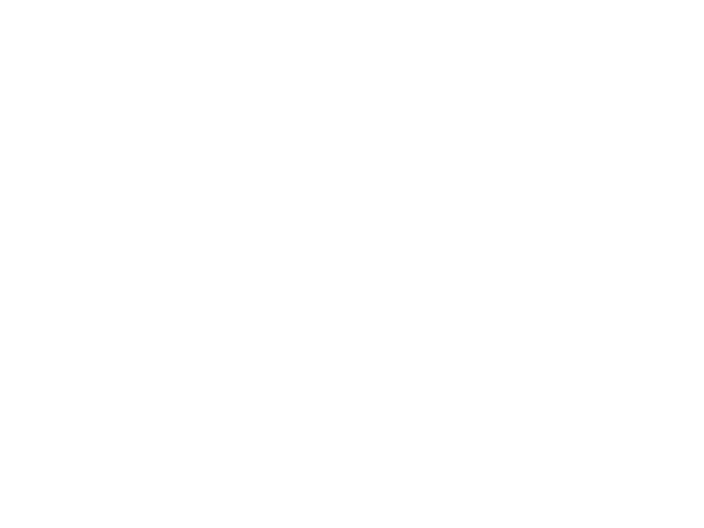

In [637]:
%matplotlib notebook

data_index = 1

plt.plot(time_list[data_index],data_list[data_index],color='b',label='Raw data')
plt.plot(time_list[data_index],filtered_data[data_index],color='r',label='Filtered data')
plt.xlabel('Time (s)')
plt.legend()

## Simulation

In [638]:
# x = data_list[data_index]
x = filtered_data[data_index]
t = time_list[data_index]

### Stepwise filtering (for display purpose)

In [639]:
# try stepwise filtering
stepwise_filtered = []

for i in range(fltr_buffer_size,len(t)):
    current_buffer = x[i-fltr_buffer_size:i]
    current_filtered = sosfiltfilt(butter_filter,current_buffer)
    stepwise_filtered.append(current_filtered[-1])

<IPython.core.display.Javascript object>


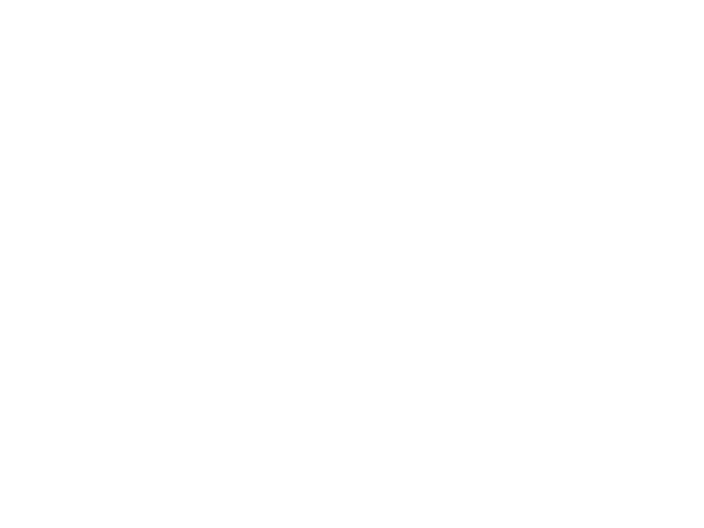

In [640]:
%matplotlib notebook

# plt.plot(t,data_list[data_index],color='k')
plt.plot(t,filtered_data[data_index],color='b')
plt.plot(t[fltr_buffer_size:],stepwise_filtered,color='r')

### Stepwise derivative

In [641]:
def offline_derivative(x,regr_buffer_size,fltr_buffer_size,stepwise_filtering=True):
    # the scikit-learn linear regression method needs an x axis
    sample_axis = np.arange(regr_buffer_size).reshape(-1,1)
    derivative_history = []
    if stepwise_filtering:
        for i in range(fltr_buffer_size,len(t)):
            current_buffer = x[i-fltr_buffer_size:i]
            current_filtered = sosfilt(butter_filter,current_buffer)
            regr.fit(sample_axis,current_filtered[len(current_filtered)-regr_buffer_size:])
            derivative_history.append(regr.coef_)
    else:
        for i in range(regr_buffer_size,len(t)):
            # no filtering at all
            current_buffer = x[i-regr_buffer_size:i]
            regr.fit(sample_axis,current_buffer)
            derivative_history.append(regr.coef_)

    for i in range(len(derivative_history)):
        derivative_history[i] = derivative_history[i][0]
        
    return np.array(derivative_history)

In [642]:
stepwise_filtering = True
derivative_history = offline_derivative(x,regr_buffer_size,fltr_buffer_size,stepwise_filtering=stepwise_filtering)

In [643]:
exact_derivative = np.gradient(filtered_data[data_index],1)

<IPython.core.display.Javascript object>


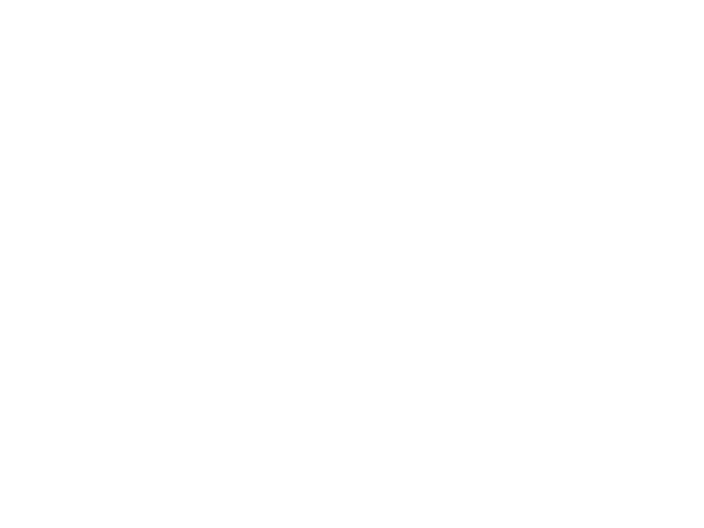

In [644]:
%matplotlib notebook

#plt.plot(t,filtered_data[data_index],color='k',label='Filtered Signal')

if stepwise_filtering:
    plt.plot(t[int(fltr_buffer_size-regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')
else:
    plt.plot(t[int(regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')

plt.plot(t,exact_derivative,color='b',label='Exact Derivative')

plt.xlabel('Time (s)')
plt.legend()

### Critical point detection

In [645]:
def critical_point(derivative_history,time,regr_buffer_size,fltr_buffer_size,num_to_wait=5,stepwise_filtering=True):
    
    critical_time = []
    current_sign = True
    sign_buffer = []

    for i in range(len(derivative_history)):
        # initialize sign buffer and current sign
        if i == 0:
            current_sign = (derivative_history[0]>0)
            sign_buffer = [derivative_history[0]>0]*num_to_wait
            continue

        # update sign buffer
        sign_buffer.append(derivative_history[i]>0)
        sign_buffer.pop(0)

        # determine if a critical point is passed
        # need more efficient execution for real time
        flip = True
        for sign in sign_buffer:
            if current_sign == sign:
                flip = False
                break

        # change current sign, note down lateset critical point
        if flip:
            # take the start of num_to_wait consecutive changed signs as the critical point
            if stepwise_filtering:
                critical_time.append(t[i+fltr_buffer_size-int(regr_buffer_size/2)-num_to_wait])
            else:
                critical_time.append(t[i+int(regr_buffer_size/2)-num_to_wait])

            current_sign = sign_buffer[-1]

        # the systematic delay is num_to_wait + regr_buffer_size/2
        
    return critical_time

In [646]:
critical_time = critical_point(derivative_history,t,regr_buffer_size,\
                                fltr_buffer_size,num_to_wait=5,stepwise_filtering=stepwise_filtering)

<IPython.core.display.Javascript object>


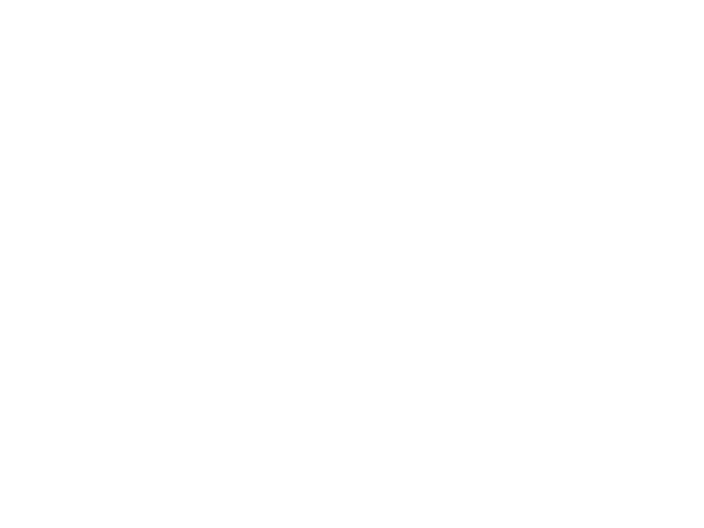

Text(0, 0.5, 'Quarter Interval (s)')

In [647]:
%matplotlib notebook

interval = np.diff(critical_time)
plt.plot(np.arange(len(interval)),interval)
plt.scatter(np.arange(len(interval)),interval,c='r')
plt.ylabel('Quarter Interval (s)')

<IPython.core.display.Javascript object>


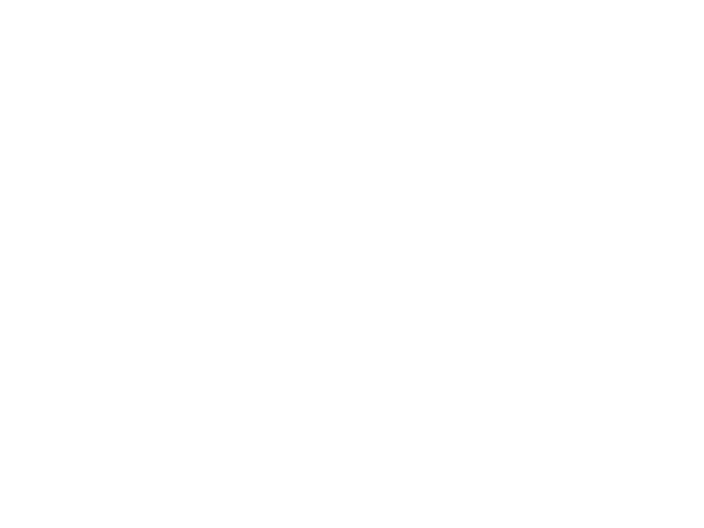

In [648]:
%matplotlib notebook

plt.plot(t,np.array(filtered_data[data_index])*0.05,color='k',label='Filtered Signal')
plt.plot(t,exact_derivative,color='b',label='Exact Derivative')

if stepwise_filtering:
    plt.plot(t[int(fltr_buffer_size-regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history),\
             color='r',label='Estm. Derv (Scaled)')
else:
    plt.plot(t[int(regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history),\
             color='r',label='Estm. Derv (Scaled)')

plt.scatter(critical_time,[0]*len(critical_time),s=20,color='orange',label='Estimated Critical')

# plt.ylabel('Magnitude ($uV$)')
# plt.xlabel('Time (s)')
# plt.legend()

### Slope update

In [649]:
def update_slope(critical_time,default_slope,sampling_rate=1500):
    slope_history = [default_slope]

    for i in range(1,len(critical_time)):
        current_interval = (critical_time[i] - critical_time[i-1])*sampling_rate
        current_slope = np.pi/current_interval
        slope_history.append(current_slope)
        
    return dict(zip(critical_time,slope_history))

In [650]:
test = update_slope(critical_time,default_slope,sampling_rate=sampling_rate)

### Phase interpolation

In [675]:
def interpolate_phase(derivative_history,time,critical_time,slope_profile,sampling_rate=1500):
    initial_phase = None
    next_critical_phase = None
    last_critical_phase = None

    # if the derivative starts positive, the next critical point should be pi; otherwise it's 0 (2pi)

    # what if for some particularly noisy data the initial position happens to be somewhere around a critical point 
    # and the derivative value jiggles so its sign is messed up? Then the initial phase position, then everything after, 
    # would be wrong

    if derivative_history[0]>0:
    #     initial_phase = 0
    #     last_critical_phase = 0
    #     next_critical_phase = np.pi

        initial_phase = np.pi
        last_critical_phase = np.pi
        next_critical_phase = 0
    else:
        initial_phase = 0
        last_critical_phase = 0
        next_critical_phase = np.pi

    #     initial_phase = np.pi
    #     last_critical_phase = np.pi
    #     next_critical_phase = 0
    
    phase_history = [initial_phase]
    last_critical_point = 0
    current_slope = default_slope

    for time in t:

        if time <= critical_time[0]: continue

        # update current_slope upon passing each critical point
        try:
            if time == critical_time[last_critical_point+1]:
                last_critical_point = last_critical_point+1
                current_slope = slope_profile[critical_time[last_critical_point]]
                # correct phase at every critical point, which has known phase position
                last_critical_phase = next_critical_phase
                phase_history.append(next_critical_phase)
                next_critical_phase = (next_critical_phase + np.pi) % (2*np.pi)
                continue

        # for the last segment, last_critical_point + 1 would make index out of bound
        except IndexError:
            current_slope = slope_profile[critical_time[-1]]


        # calculate current phase based on current slope
        # multiply total_time_elapsed by sampling rate because the slope is phase vs. sample count

        #current_phase = (initial_phase+(time-critical_time[0])*sampling_rate*current_slope) % (2*np.pi)
        current_phase = last_critical_phase + (time-critical_time[last_critical_point])*sampling_rate*current_slope
        phase_history.append(current_phase)
        
    return phase_history

In [671]:
phase_history = interpolate_phase(derivative_history,t,critical_time,test,sampling_rate=sampling_rate)

In [672]:
def detection_start(time,critical_time):
    phase_detection_start = 0
    for i in range(len(t)):
        if critical_time[0] == t[i]:
            phase_detection_start = i
            break
    return phase_detection_start

<IPython.core.display.Javascript object>


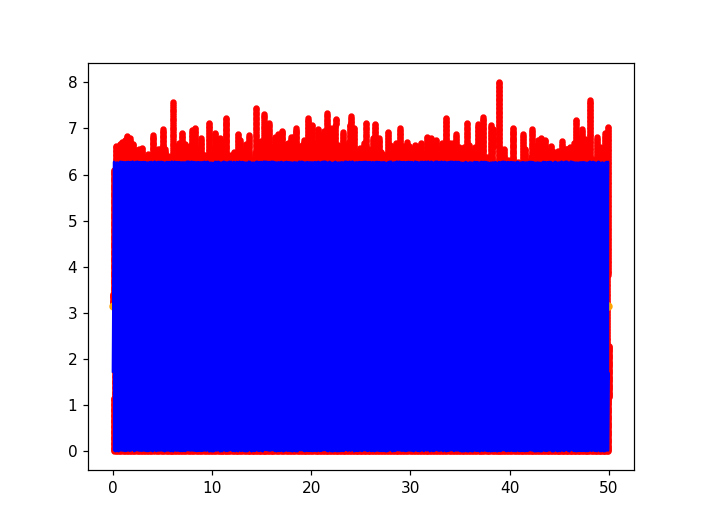

In [673]:
%matplotlib notebook

phase_detection_start = detection_start(t,critical_time)

exact_phase = np.angle(hilbert(filtered_data[data_index]))+np.pi

plt.plot(t,exact_phase,color='b',label='Exact phase')
plt.scatter(t[phase_detection_start:],phase_history,s=10,color='r',label='Estimated phase')
plt.scatter(critical_time,[np.pi]*len(critical_time),s=20,color='orange',label='Estimated Critical')
# plt.legend()

## Analysis

### Critical points

In [655]:
# the magnitude of derivative is messed up, but critical points should not be affeced
critical_time_truth = []

# detect critical points with ground truth derivative
current_sign = (exact_derivative[0]>0)
for i in range(len(exact_derivative)):
    if not ((exact_derivative[i]>0) == current_sign):
        critical_time_truth.append(t[i-1])
        current_sign = (exact_derivative[i]>0)

In [656]:
print(len(critical_time_truth))
print(len(critical_time))

667
666


<IPython.core.display.Javascript object>


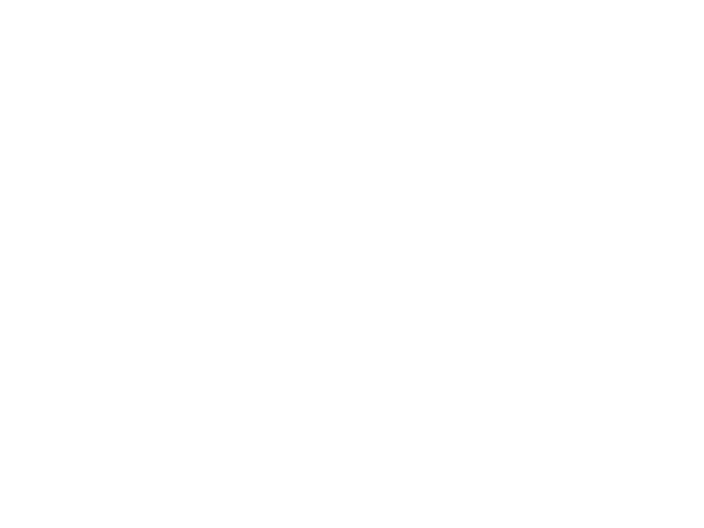

<BarContainer object of 10 artists>

In [657]:
%matplotlib notebook

cross_correlation = [(time_1 - time_2)*1000 for time_1 in critical_time_truth for time_2 in critical_time]
diff_bar_critical, bin_edges_critical = np.histogram(cross_correlation, range=(0,1000))
plt.bar(bin_edges_critical[:-1],diff_bar_critical)

### Phase

In [658]:
# Mean squared error (rad)

def RMS_error(phase_history,exact_phase,phase_detection_start):
    return np.sqrt(np.square(np.subtract(exact_phase[phase_detection_start:],phase_history)).mean()) 

MSE = RMS_error(phase_history,exact_phase,phase_detection_start)
MSE

2.128275787730195

<IPython.core.display.Javascript object>


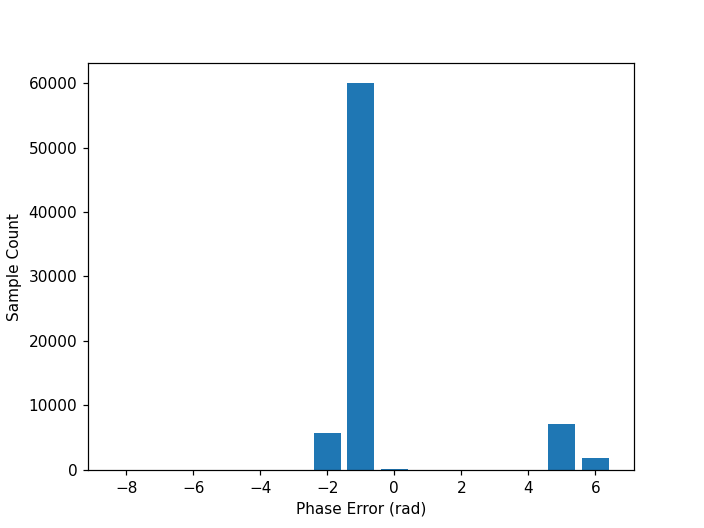

Text(0, 0.5, 'Sample Count')

In [659]:
# Phase cross correlation
%matplotlib notebook

diff_bar_phase, bin_edges_phase = np.histogram(np.subtract(phase_history,exact_phase[phase_detection_start:]), range(-8,8))
plt.bar(bin_edges_phase[:-1],diff_bar_phase)
plt.xlabel('Phase Error (rad)')
plt.ylabel('Sample Count')

In [660]:
# Acceptance rate
def acceptance_rate(phase_history,exact_phase,phase_detection_start,error_bound=0.2):
    acceptance_status = [np.abs(np.subtract(phase_history[i],exact_phase[phase_detection_start+i])) \
                         <= (np.abs(exact_phase[phase_detection_start+i])*error_bound) for i in range(len(phase_history))]
    acceptance_rate = sum(acceptance_status)/len(acceptance_status)
    return acceptance_rate

In [661]:
error_bound = 0.2 # 20%
result = acceptance_rate(phase_history,exact_phase,phase_detection_start,error_bound=0.2)
result

0.4205193244776717

### Hyperparameter

In [683]:
# two main hyper-parameters: filtering buffer size and num_to_wait. regr_buffer_size doesn't seem to matter that much

# offline_derivative(x,regr_buffer_size,fltr_buffer_size,stepwise_filtering=True)
# critical_point(derivative_history,time,regr_buffer_size,fltr_buffer_size,num_to_wait=5,stepwise_filtering=True)
# update_slope(critical_time,default_slope,sampling_rate=1500)
# interpolate_phase(derivative_history,time,critical_time,slope_profile,sampling_rate=1500)
# detection_start(time,critical_time)
# RMS_error(phase_history,exact_phase,phase_detection_start)
# acceptance_rate(phase_history,exact_phase,phase_detection_start,error_bound=0.2)

matrix_size = 10
fltr_increment = 50
num_wait_increment = 1
acceptance_matrix = np.zeros((matrix_size,matrix_size),dtype=float)
error_matrix = np.zeros((matrix_size,matrix_size),dtype=float)

for i in range(matrix_size):
    curr_derv = offline_derivative(x,regr_buffer_size,fltr_increment*(i+1),stepwise_filtering=True)
    for j in range(matrix_size):        
        curr_crpt = critical_point(curr_derv,t,regr_buffer_size,fltr_increment*(i+1),\
                                   num_to_wait=num_wait_increment*(j+1),stepwise_filtering=True)
        curr_slope = update_slope(curr_crpt,default_slope,sampling_rate=1500)
        curr_phase = interpolate_phase(curr_derv,t,curr_crpt,curr_slope,sampling_rate=1500)
        curr_start = detection_start(t,curr_crpt)
        
        acceptance_matrix[i,j] = acceptance_rate(curr_phase,exact_phase,curr_start,error_bound=0.2)
        error_matrix[i,j] = RMS_error(curr_phase,exact_phase,curr_start)

<IPython.core.display.Javascript object>


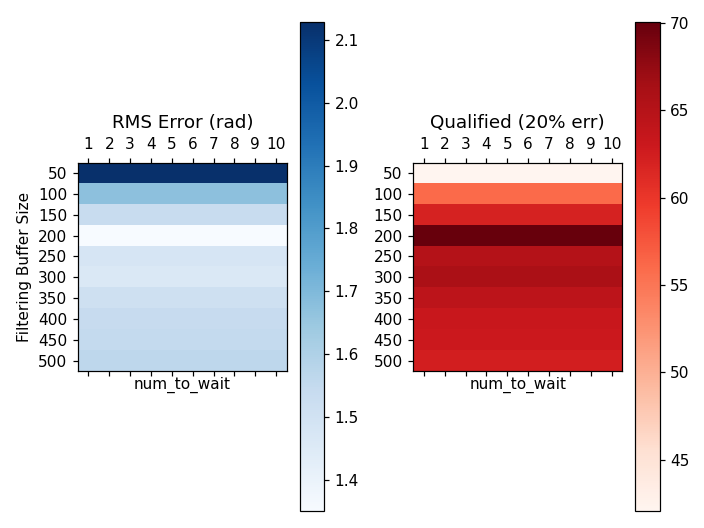

In [706]:
%matplotlib notebook

ax_ylabels = [str((i+1)*fltr_increment) for i in range(matrix_size)]
ax_xlabels = [str((i+1)*num_wait_increment) for i in range(matrix_size)]

fig,(ax1,ax2) = plt.subplots(1,2)
ax1_mat = ax1.matshow(error_matrix, cmap=plt.cm.Blues)
ax1.set_yticks(np.linspace(0,matrix_size-1,matrix_size))
ax1.set_yticklabels(ax_ylabels)
ax1.set_xticks(np.linspace(0,matrix_size-1,matrix_size))
ax1.set_xticklabels(ax_xlabels)
ax1.set_ylabel('Filtering Buffer Size')
ax1.set_xlabel('num_to_wait')
ax1.set_title('RMS Error (rad)')

ax2_mat = ax2.matshow(acceptance_matrix*100, cmap=plt.cm.Reds)
ax2.set_xlabel('num_to_wait')
ax2.set_yticks(np.linspace(0,matrix_size-1,matrix_size))
ax2.set_yticklabels(ax_ylabels)
ax2.set_xticks(np.linspace(0,matrix_size-1,matrix_size))
ax2.set_xticklabels(ax_xlabels)
ax2.set_title('Qualified ('+str(int(error_bound*100))+'% err)')

fig.colorbar(ax1_mat,ax=ax1)
fig.colorbar(ax2_mat,ax=ax2)
fig.tight_layout()